## Architecture:
**Vgg16** is built on top of **Keras** which sits on top of **Theano** (in our case but it can also be Tensorflow) which in turn sits on top of **CUDA** (cuDNN.)

### Note:
1) To use Tensorflow as the Keras backend instead of Theano (for using multiple GPUs to achieve higher accuracy later on) change the configurations in *~/.keras/keras.json*

2) For switching between GPU (if a GPU is available) and CPU usage in Theano change the configuration in *~/.theanorc*

In [25]:
import os

import keras
from keras.preprocessing import image

from matplotlib import pyplot as plt
import numpy as np
from numpy.random import permutation
np.set_printoptions(precision=4, linewidth=100)

In [2]:
# Contains some utilty functions
# TODO Figure out what "reload" does
import utils; reload(utils)
from utils import plots
# Contains the trained Vgg16 model (2014 winner of ImageNet)
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [3]:
# For showing the plots in this webpage
%matplotlib inline

In [26]:
# Path containing input data items
# path = "../data/dogscats/"
path = "../data/dogscats/sample/"
# Path containing trained models
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

No larger than 64 batch size is recommended. 

The idea of a batch is to keep most (ideally all) of the GPU busy processing images; using just one image at a time is not fully utilizing all the cores in the GPU but using the entire data set is also not possible due to the memory constraints on the GPU.

In [5]:
# If running out of memory or using an older GPU, decrease this number
batch_size = 4

In [6]:
vgg = Vgg16()
# Grab a few images at a time for training and validation
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


We can first see a batch of images and the labels images in this batch have.

In [7]:
imgs, labels = next(batches)

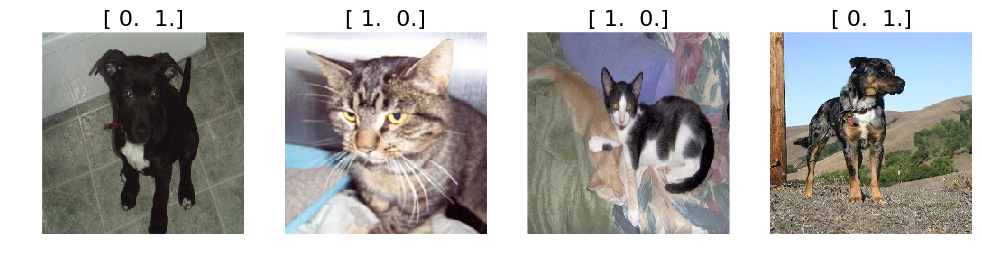

In [8]:
plots(imgs, titles=labels)

Then we use the same images and ignore their original labels and make the pre-trained Vgg16 model classify these images (to see what the model thinks these images are.)

The output will contain probabilities, class indices and class names.

In [9]:
vgg.predict(imgs, True)

(array([ 0.1152,  0.7001,  0.2421,  0.1634], dtype=float32),
 array([227, 281, 158, 234]),
 [u'kelpie', u'tabby', u'toy_terrier', u'Rottweiler'])

However, at this stage, the classes can be any of the 1000 classes that the Vgg16 model is already trained on. To tailor this model for our needs, we can **finetune** it so that it takes in our training data (from the batches we created above) and only classifies the images using the classes we have labeled our training data with. 

(The way it identifies which classes the training data can have is by following the directory structure of the *dogscats* data set.)

*Note:*
In **finetune** we modify the structure of the model to meet our data set - for example, earlier, the output layer would have 1000 categories but now we would only need 2. Such things are done in the finetune function.
In **fit** we compute the new weights of the model and the actual re-training happens here.

In [10]:
vgg.finetune(batches)

Now we **fit** the parameters of the model using training data and the accuracy is reported on the validation set after each epoch. 

(An epoch is one full pass through the training data.)

In [11]:
vgg.fit(batches, val_batches, nb_epoch=5)

Epoch 1/5
16/16 [==============================] - 8s - loss: 2.1029 - acc: 0.4375 - val_loss: 0.3325 - val_acc: 0.8750
Epoch 2/5
16/16 [==============================] - 7s - loss: 0.1339 - acc: 1.0000 - val_loss: 0.2950 - val_acc: 0.8750
Epoch 3/5
16/16 [==============================] - 8s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.3688 - val_acc: 0.8750
Epoch 4/5
16/16 [==============================] - 8s - loss: 0.0321 - acc: 1.0000 - val_loss: 0.4360 - val_acc: 0.8750
Epoch 5/5
16/16 [==============================] - 7s - loss: 0.0535 - acc: 0.9375 - val_loss: 0.4507 - val_acc: 0.8750


In [27]:
vgg.model.save_weights(model_path+'finetune1.h5')

**Tip for debugging:**

It is a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5)


Vgg **test** function is a utility function that first calls get_batches on the provided path and on those batches, it runs the prediction and puts all the results into one array and returns that.

Using the validation set instead of the test set because we know the correct answers to the validation set so that will help us in debugging.

In [12]:
val_batches, probs = vgg.test(path+'valid', batch_size=batch_size)
labels = val_batches.classes
filenames = val_batches.filenames
# Pick the first column, which in this case would represent probability of the image being a cat
probs = probs[:,0]  
# If the probability of it being a cat is high then assign class label 1 else assign class label 0
preds = np.round(1-probs)

Found 8 images belonging to 2 classes.


In [13]:
probs[:8]

array([ 1.    ,  1.    ,  1.    ,  0.8991,  0.0036,  0.001 ,  0.0172,  0.9691], dtype=float32)

In [14]:
preds[:8]

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.], dtype=float32)

In [15]:
# Number of images to view for each category
n_view = 4

In [35]:
def plots_idx(idx, titles=None):
    """Helper function for plotting images by index in the validation set."""
    if len(idx) > 0:
        plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)
    else:
        print "Nothing to plot!"

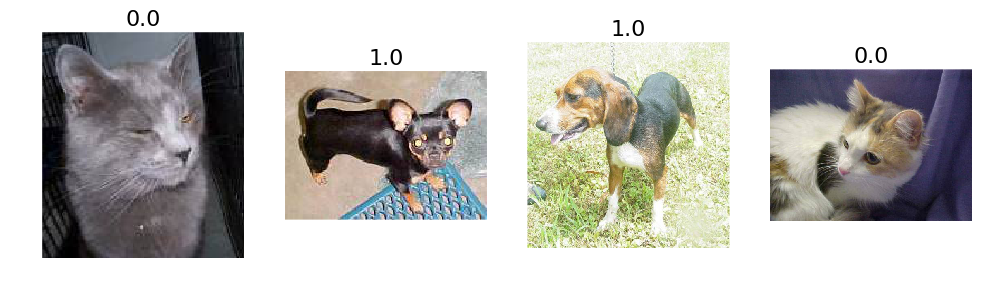

In [17]:
# 1. A few correct labels at random
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, preds[idx])

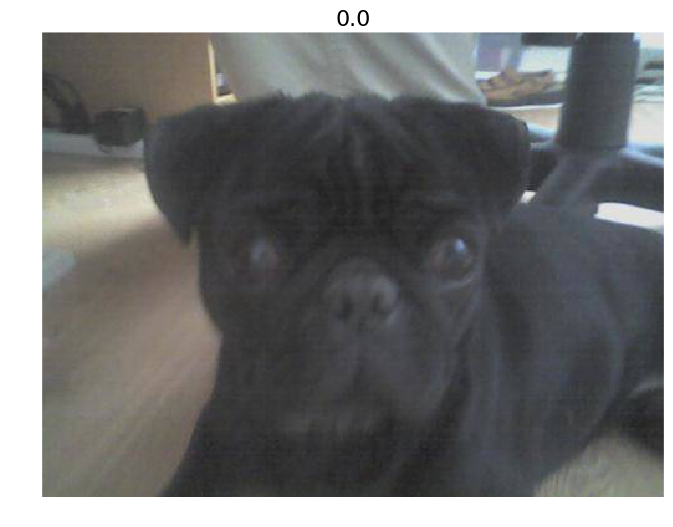

In [18]:
# 2. A few incorrect labels at random
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, preds[idx])

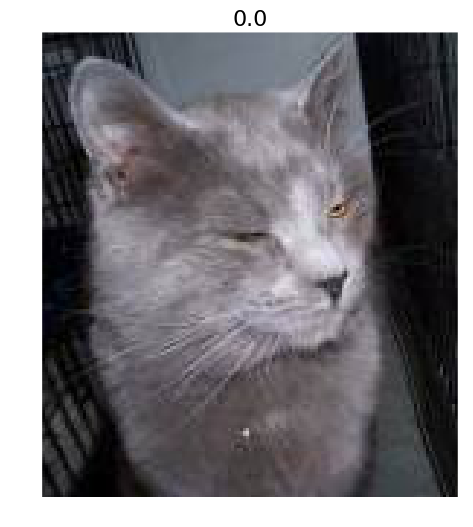

In [19]:
# 3. The images we were most confident were class 0, and are actually class 1
correct_class_0 = np.where((preds==0) & (preds!=labels))[0]
idx = np.argsort(probs[correct_class_0])[::-1][:n_view]
plots_idx(idx, preds[idx])

In [32]:
# 3. The images we were most confident were class 1, and are actually class 1
correct_class_1 = np.where((preds==1) & (preds!=labels))[0]
idx = np.argsort(probs[correct_class_1])[::-1][:n_view]
plots_idx(idx, preds[idx])

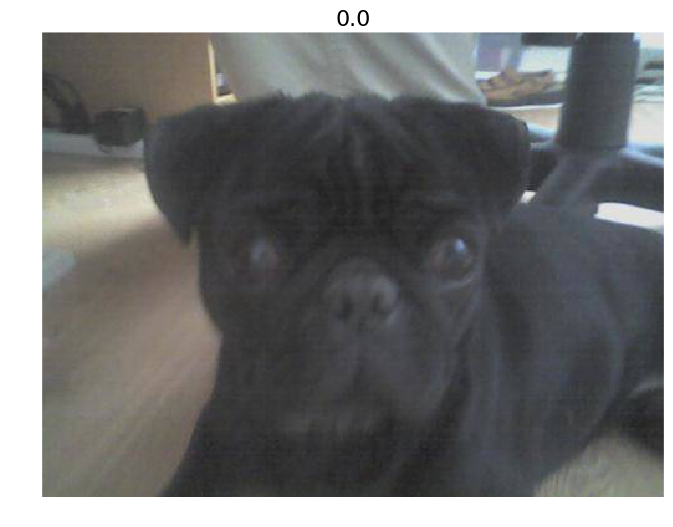

In [33]:
# 4. The images we were most confident were class 0, but are actually class 1
incorrect_class_0 = np.where((preds==0) & (preds!=labels))[0]
idx = permutation(incorrect_class_0)[:n_view]
plots_idx(idx, preds[idx])

In [36]:
# 4. The images we were most confident were class 1, but are actually class 0
incorrect_class_1 = np.where((preds==1) & (preds!=labels))[0]
idx = permutation(incorrect_class_1)[:n_view]
plots_idx(idx, preds[idx])

Nothing to plot!


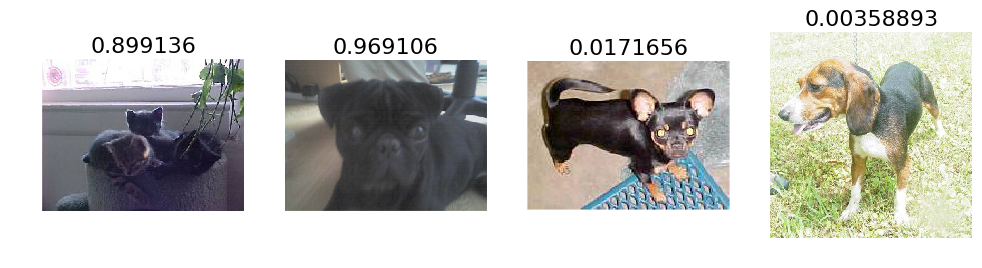

In [37]:
# 5. The most uncertain labels (ie those with probability closest to 0.5)
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])